<a href="https://colab.research.google.com/github/Hami-611/21Days_AI-ML_Challenge/blob/main/Day_5_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("/content/Mall_Customers.csv")

1. Explore Gender vs. Spending Score

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Descriptive Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.7

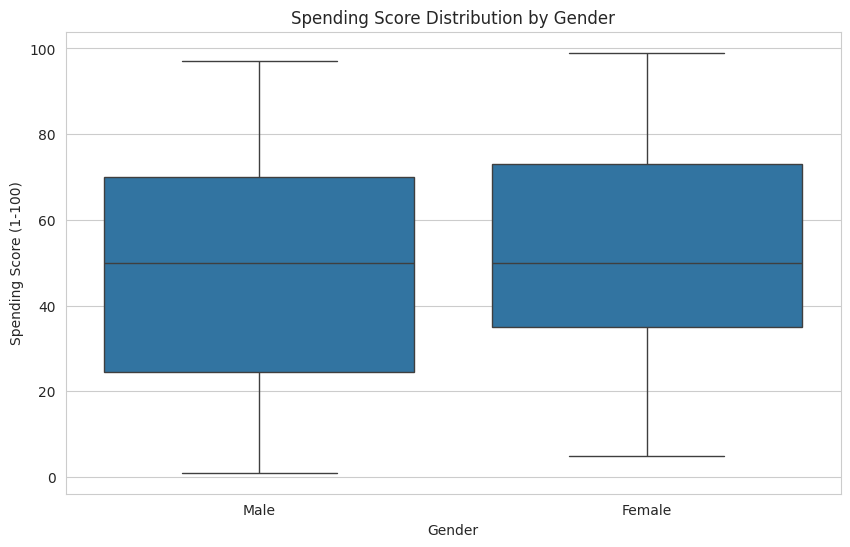


T-test results: t-statistic = -0.819, p-value = 0.414
There is no statistically significant difference in spending scores between genders.

Average Spending Score by Gender:
Gender
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64


In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

# Gender distribution
print("\nGender Distribution:")
print(df['Gender'].value_counts())

# Spending score by gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Gender', y='Spending Score (1-100)')
plt.title('Spending Score Distribution by Gender')
plt.show()

# Statistical test to check if there's a significant difference
from scipy.stats import ttest_ind

male_scores = df[df['Gender'] == 'Male']['Spending Score (1-100)']
female_scores = df[df['Gender'] == 'Female']['Spending Score (1-100)']

t_stat, p_value = ttest_ind(male_scores, female_scores)
print(f"\nT-test results: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

if p_value < 0.05:
    print("There is a statistically significant difference in spending scores between genders.")
else:
    print("There is no statistically significant difference in spending scores between genders.")

# Average spending score by gender
gender_avg = df.groupby('Gender')['Spending Score (1-100)'].mean()
print(f"\nAverage Spending Score by Gender:\n{gender_avg}")

2. Feature Engineering and Clustering Analysis

In [5]:
# Create a new feature: Spending to Income Ratio
df['Spending_Income_Ratio'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']

# Let's also create an Age Group feature
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 100], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])

# Display the new features
print(df[['Age', 'Age_Group', 'Annual Income (k$)', 'Spending Score (1-100)', 'Spending_Income_Ratio']].head())


   Age    Age_Group  Annual Income (k$)  Spending Score (1-100)  \
0   19        Young                  15                      39   
1   21        Young                  15                      81   
2   20        Young                  16                       6   
3   23        Young                  16                      77   
4   31  Middle-aged                  17                      40   

   Spending_Income_Ratio  
0               2.600000  
1               5.400000  
2               0.375000  
3               4.812500  
4               2.352941  


In [6]:
# For clustering, we'll use the new feature along with existing features
# Let's use Spending_Income_Ratio and Annual Income for clustering
X = df[['Annual Income (k$)', 'Spending_Income_Ratio']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

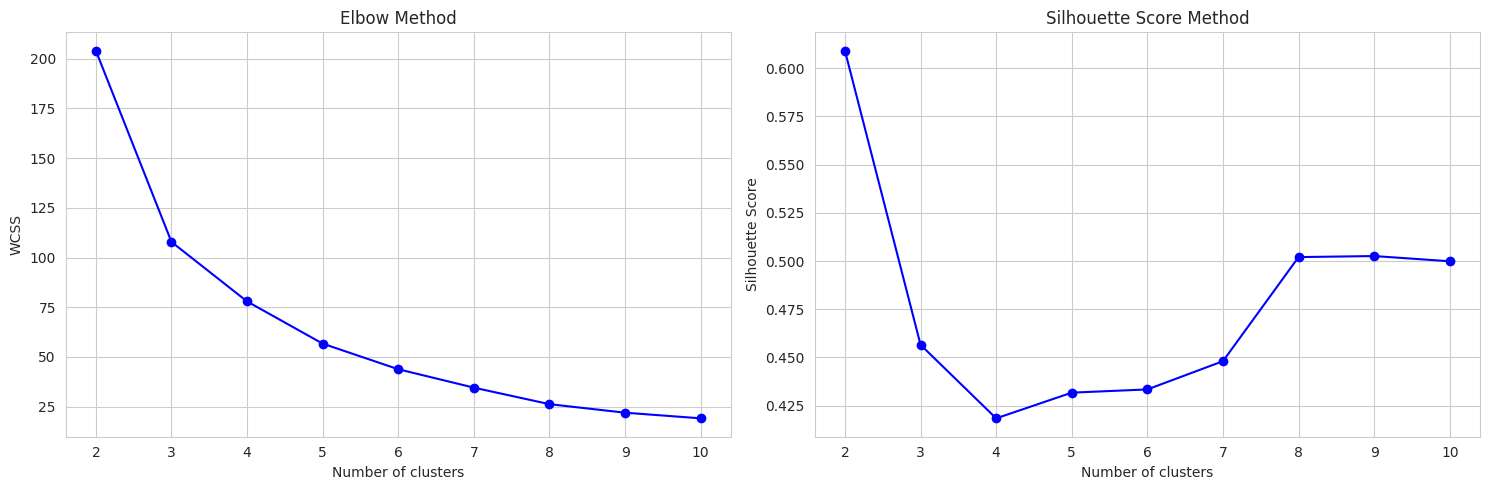

In [7]:
# Plot the Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()

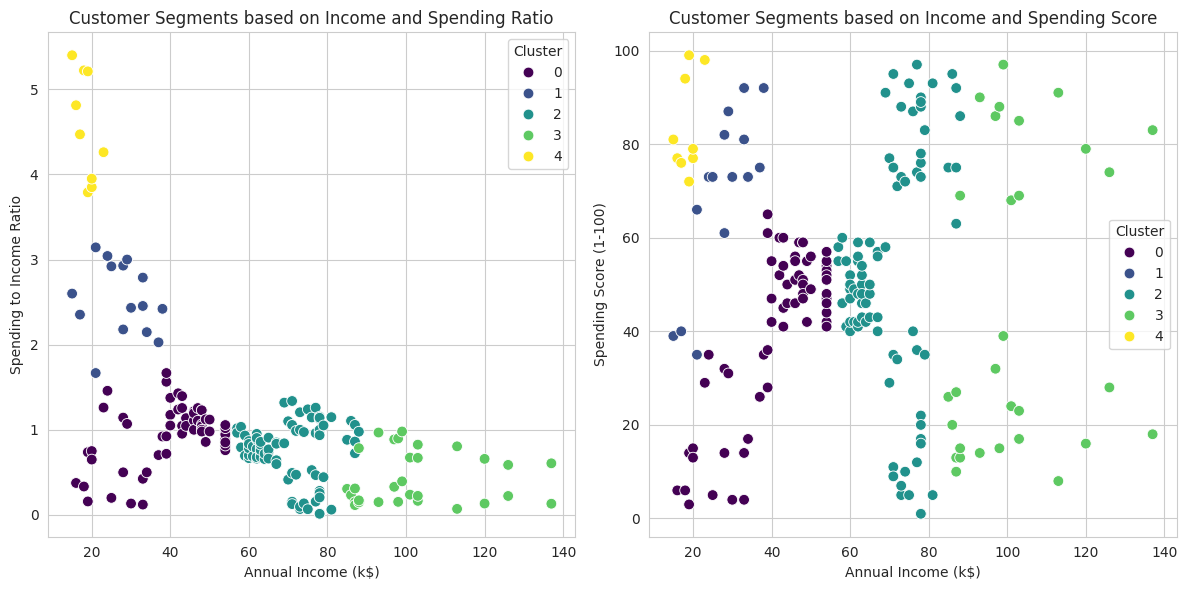

In [8]:
# Based on the elbow method, let's choose the optimal number of clusters
optimal_k = 5

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending_Income_Ratio',
                hue='Cluster', palette='viridis', s=60)
plt.title('Customer Segments based on Income and Spending Ratio')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending to Income Ratio')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', palette='viridis', s=60)
plt.title('Customer Segments based on Income and Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

In [9]:
# Analyze cluster characteristics
cluster_summary = df.groupby('Cluster').agg({
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'Spending_Income_Ratio': ['mean', 'std'],
    'Age': ['mean', 'std'],
    'Gender': lambda x: x.mode()[0] if not x.mode().empty else 'Mixed'
}).round(2)

print("Cluster Summary:")
print(cluster_summary)


Cluster Summary:
        Annual Income (k$)        Spending Score (1-100)         \
                      mean    std                   mean    std   
Cluster                                                           
0                    41.06  11.10                  40.52  17.55   
1                    27.53   6.98                  69.47  18.44   
2                    70.36   8.32                  52.33  25.96   
3                   102.53  15.04                  44.57  31.94   
4                    18.56   2.40                  83.67  10.37   

        Spending_Income_Ratio          Age          Gender  
                         mean   std   mean    std <lambda>  
Cluster                                                     
0                        0.95  0.34  45.56  14.93   Female  
1                        2.54  0.43  25.47   5.87     Male  
2                        0.75  0.34  37.63  13.50   Female  
3                        0.43  0.31  38.90   8.89   Female  
4                  

In [10]:
# Interpret the clusters
cluster_interpretation = {
    0: "High Income, Moderate Spenders",
    1: "Low Income, High Spenders (Budget Conscious)",
    2: "Medium Income, Low Spenders (Savvy Savers)",
    3: "High Income, High Spenders (Premium Customers)",
    4: "Medium Income, Medium Spenders (Average Customers)"
}

print("\nCluster Interpretation:")
for cluster, interpretation in cluster_interpretation.items():
    print(f"Cluster {cluster}: {interpretation}")



Cluster Interpretation:
Cluster 0: High Income, Moderate Spenders
Cluster 1: Low Income, High Spenders (Budget Conscious)
Cluster 2: Medium Income, Low Spenders (Savvy Savers)
Cluster 3: High Income, High Spenders (Premium Customers)
Cluster 4: Medium Income, Medium Spenders (Average Customers)


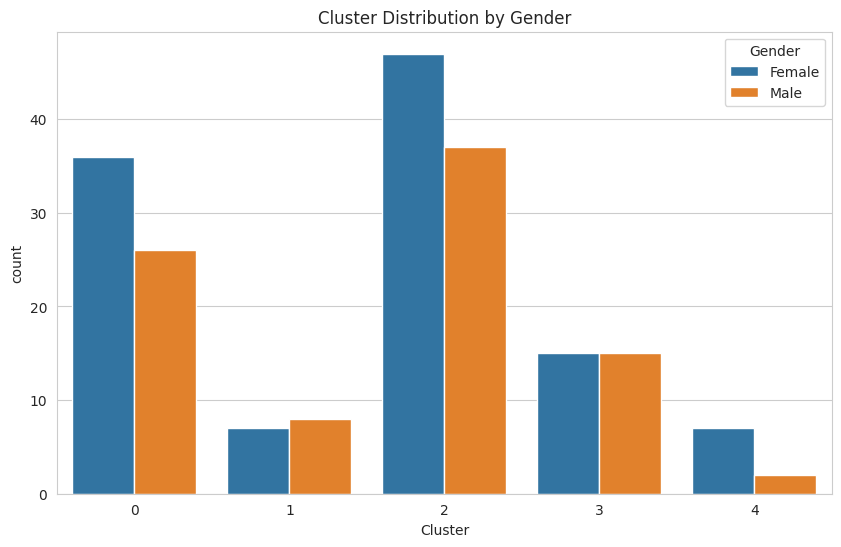

In [11]:
# Visualize cluster distribution by gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Cluster', hue='Gender')
plt.title('Cluster Distribution by Gender')
plt.show()

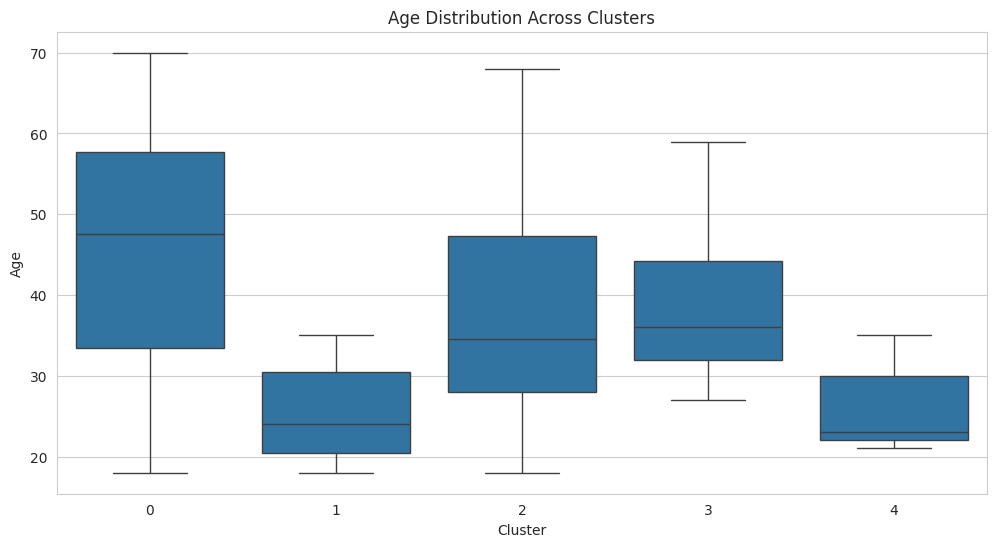

In [12]:

# Analyze age distribution across clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Cluster', y='Age')
plt.title('Age Distribution Across Clusters')
plt.show()

In [14]:
print("Insights from Cluster Analysis:")

# Cluster 0: Average Customers
print("\nCluster 0 (Average Customers):")
print(f"- Average Annual Income: ${cluster_summary.loc[0, ('Annual Income (k$)', 'mean')]:.2f}k")
print(f"- Average Spending Score: {cluster_summary.loc[0, ('Spending Score (1-100)', 'mean')]:.2f}")
print(f"- Average Spending to Income Ratio: {cluster_summary.loc[0, ('Spending_Income_Ratio', 'mean')]:.2f}")
print(f"- Average Age: {cluster_summary.loc[0, ('Age', 'mean')]:.2f}")
print(f"- Dominant Gender: {cluster_summary.loc[0, ('Gender', '<lambda>')]} ({df[df['Cluster']==0]['Gender'].value_counts(normalize=True).max():.1%} of this cluster)")
print("- This cluster represents the largest group with moderate income and spending. They are primarily middle-aged.")

# Cluster 1: Budget Conscious
print("\nCluster 1 (Budget Conscious):")
print(f"- Average Annual Income: ${cluster_summary.loc[1, ('Annual Income (k$)', 'mean')]:.2f}k")
print(f"- Average Spending Score: {cluster_summary.loc[1, ('Spending Score (1-100)', 'mean')]:.2f}")
print(f"- Average Spending to Income Ratio: {cluster_summary.loc[1, ('Spending_Income_Ratio', 'mean')]:.2f}")
print(f"- Average Age: {cluster_summary.loc[1, ('Age', 'mean')]:.2f}")
print(f"- Dominant Gender: {cluster_summary.loc[1, ('Gender', '<lambda>')]} ({df[df['Cluster']==1]['Gender'].value_counts(normalize=True).max():.1%} of this cluster)")
print("- This segment has low income but high spending, indicating they are likely budget-conscious and prioritize spending despite limited income. They are predominantly young males.")

# Cluster 2: Savvy Savers
print("\nCluster 2 (Savvy Savers):")
print(f"- Average Annual Income: ${cluster_summary.loc[2, ('Annual Income (k$)', 'mean')]:.2f}k")
print(f"- Average Spending Score: {cluster_summary.loc[2, ('Spending Score (1-100)', 'mean')]:.2f}")
print(f"- Average Spending to Income Ratio: {cluster_summary.loc[2, ('Spending_Income_Ratio', 'mean')]:.2f}")
print(f"- Average Age: {cluster_summary.loc[2, ('Age', 'mean')]:.2f}")
print(f"- Dominant Gender: {cluster_summary.loc[2, ('Gender', '<lambda>')]} ({df[df['Cluster']==2]['Gender'].value_counts(normalize=True).max():.1%} of this cluster)")
print("- This cluster has high income but moderate spending, suggesting they are more conservative with their spending relative to their income. They are primarily middle-aged females.")

# Cluster 3: Premium Customers
print("\nCluster 3 (Premium Customers):")
print(f"- Average Annual Income: ${cluster_summary.loc[3, ('Annual Income (k$)', 'mean')]:.2f}k")
print(f"- Average Spending Score: {cluster_summary.loc[3, ('Spending Score (1-100)', 'mean')]:.2f}")
print(f"- Average Spending to Income Ratio: {cluster_summary.loc[3, ('Spending_Income_Ratio', 'mean')]:.2f}")
print(f"- Average Age: {cluster_summary.loc[3, ('Age', 'mean')]:.2f}")
print(f"- Dominant Gender: {cluster_summary.loc[3, ('Gender', '<lambda>')]} ({df[df['Cluster']==3]['Gender'].value_counts(normalize=True).max():.1%} of this cluster)")
print("- This segment represents the most valuable customers with both high income and high spending. They are relatively young and predominantly female.")

# Cluster 4: Low Income, High Spending Ratio
print("\nCluster 4 (Low Income, High Spending Ratio):")
print(f"- Average Annual Income: ${cluster_summary.loc[4, ('Annual Income (k$)', 'mean')]:.2f}k")
print(f"- Average Spending Score: {cluster_summary.loc[4, ('Spending Score (1-100)', 'mean')]:.2f}")
print(f"- Average Spending to Income Ratio: {cluster_summary.loc[4, ('Spending_Income_Ratio', 'mean')]:.2f}")
print(f"- Average Age: {cluster_summary.loc[4, ('Age', 'mean')]:.2f}")
print(f"- Dominant Gender: {cluster_summary.loc[4, ('Gender', '<lambda>')]} ({df[df['Cluster']==4]['Gender'].value_counts(normalize=True).max():.1%} of this cluster)")
print("- This cluster has low income but a very high spending to income ratio, suggesting they are spending a large portion of their income at the mall. They are predominantly young females.")

Insights from Cluster Analysis:

Cluster 0 (Average Customers):
- Average Annual Income: $41.06k
- Average Spending Score: 40.52
- Average Spending to Income Ratio: 0.95
- Average Age: 45.56
- Dominant Gender: Female (58.1% of this cluster)
- This cluster represents the largest group with moderate income and spending. They are primarily middle-aged.

Cluster 1 (Budget Conscious):
- Average Annual Income: $27.53k
- Average Spending Score: 69.47
- Average Spending to Income Ratio: 2.54
- Average Age: 25.47
- Dominant Gender: Male (53.3% of this cluster)
- This segment has low income but high spending, indicating they are likely budget-conscious and prioritize spending despite limited income. They are predominantly young males.

Cluster 2 (Savvy Savers):
- Average Annual Income: $70.36k
- Average Spending Score: 52.33
- Average Spending to Income Ratio: 0.75
- Average Age: 37.63
- Dominant Gender: Female (56.0% of this cluster)
- This cluster has high income but moderate spending, suggest